In [194]:
import harp
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
sampled_events_reader = utils.TimestampedCsvReader("SampledEvents", columns=["Value.Length","Value.LongLength","Value.Rank","Value.IsReadOnly","Value.IsFixedSize","Value.IsSynchronized"])

root_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/MotionLatencyTest/MotionLatencyTest/2024-11-15T16-46-18/'
h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/MotionLatencyTest/MotionLatencyTest/2024-11-15T16-46-18/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/MotionLatencyTest/MotionLatencyTest/2024-11-15T16-46-18/HarpDataH2/'

In [196]:
# read sampled events
sampled_events = utils.load(sampled_events_reader, root_datafolder)
print(sampled_events)

                            Value.Length  Value.LongLength  Value.Rank  \
Time                                                                     
1904-01-02 01:33:58.300256             6                 6           1   
1904-01-02 01:34:01.310240             6                 6           1   
1904-01-02 01:34:04.300256             6                 6           1   
1904-01-02 01:34:07.310240             6                 6           1   
1904-01-02 01:34:10.300256             6                 6           1   
...                                  ...               ...         ...   
1904-01-02 01:43:43.320256             6                 6           1   
1904-01-02 01:43:46.310240             6                 6           1   
1904-01-02 01:43:49.320256             6                 6           1   
1904-01-02 01:43:52.320256             6                 6           1   
1904-01-02 01:43:55.320256             6                 6           1   

                            Value.IsR

In [197]:
# read harp streams
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
encoder = utils.load_harp(h2_reader.Encoder, h2_datafolder)
immediate_pulses = utils.load_harp(h2_reader.ImmediatePulses, h2_datafolder)
start_time = encoder.index[0]

Text(0, 0.5, 'Frequency')

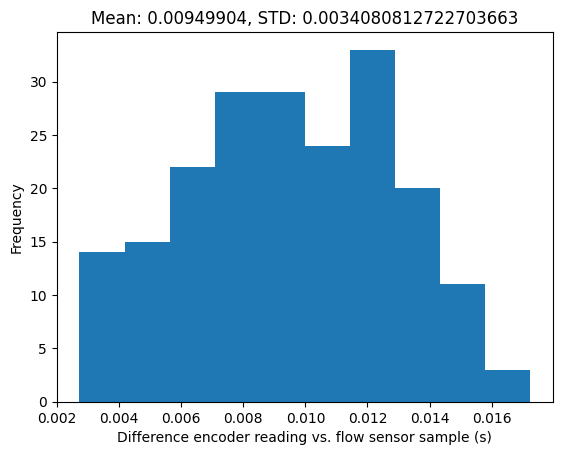

In [214]:
it = sampled_events.index[1]
min_it = it - pd.DateOffset(seconds=0.1)
max_it = it + pd.DateOffset(seconds=0.5)
initiation_times = immediate_pulses.loc[immediate_pulses['ImmediatePulses'] > 0]

offsets = list()
for i in range(len(sampled_events)):
    it = sampled_events.index[i]
    pt = initiation_times[initiation_times.index >= it].index[0]
    rise_time = encoder[encoder.index >= it].index[0]

    offset = rise_time - it
    offsets.append(offset.total_seconds())

plt.figure()
plt.hist(offsets)
plt.title("Mean: {avg}, STD: {std}".format(avg=np.mean(offsets), std=np.std(offsets)))
plt.xlabel('Difference encoder reading vs. flow sensor sample (s)')
plt.ylabel('Frequency')


Text(0.5, 1.0, 'Mean: 0.00357568, STD: 0.0015516048651638085')

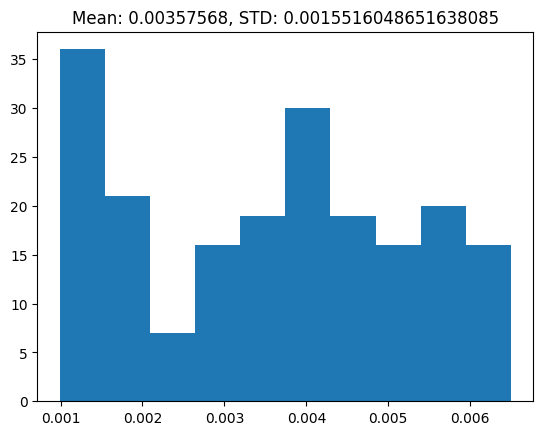

In [ ]:
# find where motion pulses initiated
initiation_times = immediate_pulses.loc[immediate_pulses['ImmediatePulses'] > 0]
termination_times = immediate_pulses.loc[immediate_pulses['ImmediatePulses'] == 0]

offsets = list()
for i in range(len(initiation_times)):
    pt = initiation_times.index[i]
    min_pt = pt - pd.DateOffset(seconds=0.5)
    max_pt = pt + pd.DateOffset(seconds=0.5)

    enc_win = encoder[min_pt:max_pt]
    last_val = encoder.loc[encoder.index < pt].iloc[-1]['Encoder']
    base_val = enc_win.iloc[0]['Encoder']
    rise_time = enc_win.loc[enc_win['Encoder'] >= (last_val)]

    offset = rise_time.index[0] - pt
    offsets.append(offset.total_seconds())

plt.figure()
plt.hist(offsets)
plt.title("Mean: {avg}, STD: {std}".format(avg=np.mean(offsets), std=np.std(offsets)))
plt.xlabel('Difference encoder reading vs. motor command (s)')
plt.ylabel('Frequency')